<a href="https://colab.research.google.com/github/Victor-Ribeiro-Acosta/Avaliando-modelo-dep-learning/blob/main/Projeto_Metricas_de_Desempenho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow
!pip install -q keras

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
%load_ext tensorboard

In [ ]:
logdir = 'log'

In [ ]:
(imagens_treino, rotulos_trieno),(imagens_teste, rotulos_teste) = datasets.mnist.load_data()
imagens_treino = imagens_treino.reshape(60000, 28, 28, 1)
imagens_teste = imagens_teste.reshape(10000, 28, 28, 1)

imagens_treino = imagens_treino / 255
imagens_teste = imagens_teste / 255

classes = [0,1,2,3,4,5,6,7,8,9]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

In [ ]:
tensorborad_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.fit(
    x = imagens_treino,
    y = rotulos_trieno,
    epochs = 5,
    validation_data = (imagens_teste, rotulos_teste)
)

Epoch 1/5
1875/1875 [==============================] - 62s 32ms/step - loss: 0.2587 - accuracy: 0.9160 - val_loss: 0.0689 - val_accuracy: 0.9787
Epoch 2/5
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0650 - accuracy: 0.9804 - val_loss: 0.0528 - val_accuracy: 0.9830
Epoch 3/5
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0437 - accuracy: 0.9867 - val_loss: 0.0353 - val_accuracy: 0.9900
Epoch 4/5
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0338 - accuracy: 0.9897 - val_loss: 0.0379 - val_accuracy: 0.9890
Epoch 5/5
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0264 - accuracy: 0.9919 - val_loss: 0.0355 - val_accuracy: 0.9894


In [ ]:
valores_verdadeiros = rotulos_teste
valores_previstos = model.predict(imagens_teste)
valores_previstos = np.argmax(valores_previstos, axis=1)

313/313 [==============================] - 3s 9ms/step


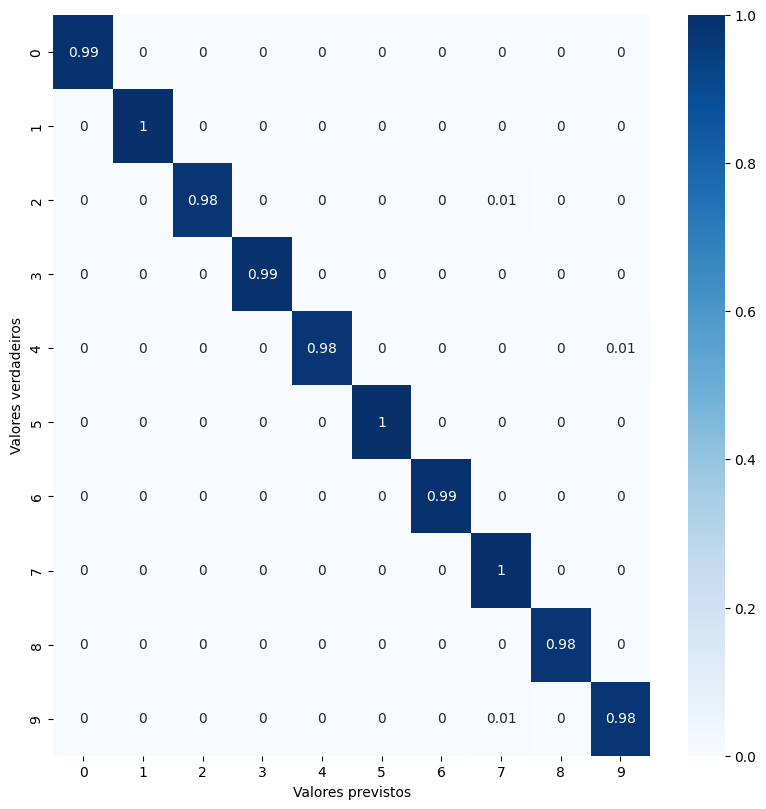

In [ ]:
mat_conf = tf.math.confusion_matrix(labels=valores_verdadeiros, predictions = valores_previstos).numpy()
mat_conf_norm = np.around(mat_conf.astype('float')/mat_conf.sum(axis=1)[:, np.newaxis], decimals=2)

mat_conf_df = pd.DataFrame(mat_conf_norm, index = classes, columns = classes)

figure = plt.figure(figsize=(8,8))
sns.heatmap(mat_conf_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('Valores verdadeiros')
plt.xlabel('Valores previstos')
plt.show()

In [ ]:
VPs = []
VNs = []
FPs = []
FNs = []

for classe in range(10):
  vp = mat_conf[classe, classe]
  vn = np.sum(mat_conf) - np.sum(mat_conf[classe, :]) - np.sum(mat_conf[: , classe])
  fp = np.sum(mat_conf[:, classe]) - vp
  fn = np.sum(mat_conf[classe, :]) - vp

  VPs.append(vp)
  VNs.append(vn)
  FPs.append(fp)
  FNs.append(fn)

# Calculando métricas de Desempenho

## Sensibilidade

In [ ]:
sensibilidade = sum(VPs) / (sum(VPs) + sum(FNs))
print('O valor de sensibilidade é de: ', sensibilidade)

O valor de sensibilidade é de:  0.9894


###Acurácia

In [ ]:
acuracia = (sum(VPs) + sum(VNs))/(sum(VPs) + sum(VNs) + sum(FPs) + sum(FNs))
print('A acurácia é de: ', acuracia)

A acurácia é de:  0.9976472155017424


###F-Score

In [ ]:
precisao = sum(VPs) / (sum(VPs) + sum(FPs))
fscore = 2*(precisao * sensibilidade) / (precisao + sensibilidade)
print('O f-score calculado é de ', fscore)

O f-score calculado é de  0.9894


Curva de ROC

In [ ]:
# Calcular TPR e FPR
TPR = sensibilidade
FPR = sum(FPs) / (sum(FPs) + sum(VNs))

# Plotar ponto na curva ROC
plt.figure()
plt.plot(FPR, TPR, marker='o', color='r', label='Ponto na curva ROC')
#plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
dataset = {}
TPR_list = []
FPR_list = []

for indice in range(10):

  TPR = VPs[indice] / (VPs[indice] + FNs[indice])
  FPR = FPs[indice] / (FPs[indice] + VNs[indice])

  TPR_list.append(TPR)
  FPR_list.append(FPR)

dataset['TPR'] = TPR_list
dataset['FPR'] = FPR_list

df = pd.DataFrame(dataset)

# Plotar ponto na curva ROC
plt.figure()
plt.plot(df['TPR'], df['FPR'], marker = 'o', color='r', label='Ponto na curva ROC')
#plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taxa de Verdadeiros Positivos (FPR)')
plt.ylabel('Taxa de Falsos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()